<a href="https://colab.research.google.com/github/ethompson93/dmri_analysis_techniques/blob/main/DTI_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Diffusion MRI – DTI Estimation**

Welcome to your first coding assignment, where we will be fitting the diffusion tensor (DT) in each voxel of the diffusion image.

The first step is to download the sample data from https://drive.google.com/drive/folders/12hHKJoAXDB-AsNTzxXf4ZvSbfq-_7qmX
 and upload it to this Google collab.

We have provided some code to get the data loaded into python variables which can be used to estimate the DT.

# The data

This coding exercise uses the [Fibercup phantom](https://tractometer.org/fibercup/home/). Fibercup is a simple phantom designed to mimic fibre configurations that are commonly found in the human brain, such as crossing and kissing fibre bundles, which are difficult to reconstruct with tractography

## Loading Variables

Below is some code to set up our data for the DT estimation. Just run the code block to import the modules and load the data. We will load the diffusion weighted images, b-values and b-vectors, and a mask of the white matter in the phantom.


In [ ]:
## Import libaries
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

## Nifti Images

# Load our nifti image as "dwi_img" and get data to "dwi"
dwi_img = nb.load('fibrecup.nii.gz')
dwi = dwi_img.get_fdata()

# repeat this with the white matter mask
mask_img = nb.load('wm_mask.nii.gz')
mask = mask_img.get_fdata()

## Gradient information
# Load our gradient text file at grad
grad = np.loadtxt('grad.txt')

# select our gradient direction as "g"
g = grad[:,0:3]

# select our b-values as "b"
b = grad[:,3]

## Reshaping
# find the index of the voxels within the white matter mask
idx = np.where(mask>0)
print(np.shape(idx))

# extract dwi values at these WM voxels to produce a matrix of
# [WM voxels x grad-dirs]. Save this as "dwi_wm"
dwi_wm = dwi[idx[0],idx[1],idx[2]]

## Extracting b0 & non-b0 diffusion signals
# find from gradients where the b-value is equal to zero as "b0idx"
b0idx = np.where(b==0)[0]

# find from gradients where the b-value is NOT equal to zero as "non_b0idx"
non_b0idx = np.where(b!=0)[0]

# Extract baseline signal ("S0") by indexing "dwi" at b0idx
S0 = dwi_wm[:,b0idx]

# Extract gradient weighted signal ("S") by indexing the "dwi" at non-b0 values
S = dwi_wm[:,non_b0idx]

This produces four variables (shape of each variable in brackets) which we will need later on:

dwi - a 4D (64, 64, 3, 65) numpy array containing the value of diffusion at each voxel of the 3D image for each diffusion direction (65 directions).

mask - a 3D (64,64,3) binary array which provides a mask of the voxels corresponding to the brain. a value of 1 i given for each brain voxel, 0 for background.

g - gradient directions. A matrix (65,3) containing the direction vector for each diffusion direction.

b - corresponding b-values (65,) for each of these gradient directions (comment on whether this is single or multi-shell data)



# Visualise the data

run the code below, this will display some of the data which we loaded in the previous section.

In [ ]:
# make a figure with three subplots for b=0, b=2000 and the wm mask
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

im = axs[0].imshow(dwi[:,:,1,0].T, origin="lower")
axs[0].set_title("b=0 s/mm^2")
plt.colorbar(im, ax=axs[0])

im = axs[1].imshow(mask[:,:,1].T, origin="lower")
axs[1].set_title("white matter mask")
plt.colorbar(im, ax=axs[1])

check_b_idx = 1
im = axs[2].imshow(dwi[:,:,1,check_b_idx].T, origin="lower")
axs[2].set_title("b=2000 s/mm^2")
plt.colorbar(im, ax=axs[2])

plt.show()

## Coding Task – Diffusion Tensor

The diffusion tensor characterises Gaussian diffusion in each brain voxel in 3D. As described in the lecture, the following equation relates the diffusion tensor to the diffusion-weighted signal:

$S_{k} = S_{0} exp(-b_{k} \hat{\textbf{g}_k^T} \textbf{D} \hat{\textbf{g}_k})$

$S_{k}$ is the signal when applying a diffusion-weighted gradient $k$ in direction $g_k$ with b-value $b_k$, $S_0$ is the signal with no diffusion weighting applied, and $\textbf{D}$ is the diffusion tensor:

$D = \begin{pmatrix}
D_{xx} & D_{xy} & D_{xz} \\
D_{xy} & D_{yy} & D_{yz} \\
D_{xz} & D_{yz} & D_{zz}
\end{pmatrix}$


**Coding Task:** create function "DT" to generate the expected diffusion signal,$S_{k}$, from the diffusion tensor.

During the fitting, we will loop through each voxel and fit the diffusion tensor within that voxel. The fitting process will minimise the sum of the squared residuals over all diffusion directions.

Use the following parameters as inputs:

*   components of the diffusion tensor (Dxx,Dxy,Dxz,Dyy,Dyz,Dzz), which are each a scalar value
*   baseline signal for the voxel when b = 0: `S0` (1,)
*   b-value of each diffusion gradient: `b` (N,)
*   a matrix of unit vectors describing each diffusion encoding gradient: `g` (N,3)

Your output should be a vector of size (N,) containing the simulated signal from the diffusion tensor for each diffusion weighted direction.

N is the number of diffusion acquisitions, in this case 64.

In [ ]:
def DT(Dxx,Dxy,Dxz,Dyy,Dyz,Dzz,S0,b,g):

    pass

In [ ]:
#@title ANSWERS:
def DT(Dxx,Dxy,Dxz,Dyy,Dyz,Dzz,S0,b,g):

    D = np.array([[Dxx,Dxy,Dxz],[Dxy,Dyy,Dyz],[Dxz,Dyz,Dzz]])
    result = np.zeros_like(b, dtype=float)  # Initialize result array
    for i in range(g.shape[0]):
        result[i] = np.exp(-b[i]*g[i,:].T@D@g[i,:])

    return S0*result

run the code below to check your function runs correctly, and outputs a vector of the expected size:

In [ ]:
vox_test = 0
d_freewater = 3e-3

result_test = DT(d_freewater,0,0,d_freewater,0,d_freewater,
                 S0[vox_test,:], b[non_b0idx], g[non_b0idx,:])

print(result_test)
print(result_test.shape)

## Calculate residuals

Now we want to fit the model to our data. We have our aquisition parameters `b` and `g`, and measured values foro `S0`. We need to find the components of the diffusion tensor that give the best model fit to the data.

We'll be using scipy's non-linear least squares optimiser to fit the model. We have provided the code for this below. Take a look at the documentation to help you understand the inputs to the least_squares function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html. The first input we need to provide is a function which computes the vector of residuals, with the signature `fun(x, *args, **kwargs)`. Here, `x` is the variable being optimized. Since the minimization is performed with respect to `x`, we need to combine all elements of the diffusion tensor (`Dxx`, `Dxy`, `Dxz`, `Dyy`, `Dyz` and `Dzz`) as a single NumPy array (ndarray) and pass it as `x`.

We have created a `residuals` function that calculates the difference between the measured signal `S` and the simulated signal from the `DT` function:

In [ ]:
def residuals(x, S0, b, g, S):
  # x = (Dxx,Dxy,Dxz,Dyy,Dyz,Dzz)
  r = DT(x[0], x[1], x[2], x[3], x[4], x[5], S0, b, g) - S
  return r

We pass this function to the `least_squares` optimiser, which uses it to minimise the sum-of-squared error between the model and the data. Take some time to look through the code below to understand the different parameters.

In [ ]:
Nvox = np.shape(S0)[0]

# set up empty arrays to store the parameter estimates for each voxel
D_estimates = np.zeros((3,3,Nvox))
principal_dir = np.zeros((Nvox,3))

d_freewater = 3e-3 # approximate diffusivity of free water in mm^2/s

for i in range(Nvox):
  res = least_squares(residuals,
              x0 = np.zeros(6), # initial guesses for D
              args=(S0[i,:], b[non_b0idx], g[non_b0idx,:], S[i,:]), # additional arguments to pass to the sum_squared_error function
              bounds = ([x*d_freewater for x in [0,-1,-1,0,-1,0]]
                        ,[x*d_freewater for x in [1,1,1,1,1,1]]), # lower and upper bounds for Dxx,Dxy,Dxz,Dyy,Dyz,Dzz
              ftol = 1e-9, xtol=1e-9) # tolerance values for termination

  Dxx,Dxy,Dxz,Dyy,Dyz,Dzz = res.x
  D_estimates[:,:,i] = [[Dxx,Dxy,Dxz],[Dxy,Dyy,Dyz],[Dxz,Dyz,Dzz]]

  DTeig = np.linalg.eig(D_estimates[:,:,i])
  principal_i = np.argmax(np.abs(DTeig[0]))
  principal_dir[i,:] = DTeig[1][:,principal_i]


This can take a few minutes.

In the meantime, have a look at the extension tasks below.

We have set the limits for the diffusion tensor components within the least squares fit. Speak to your group about why we have chosen these particular limits.

# Visualise each component of the diffusion tensor (Dxx, Dxy, Dxz, Dyy, Dyz, Dzz)

Once the least-squares fit has finished running, we can visualise our results.

First, we will visualise each of the components of the diffusion tensor.

In [ ]:
D_estimates_reshape = np.zeros([3,3,mask.shape[0],mask.shape[1],mask.shape[2]])
D_estimates_reshape[:,:,idx[0],idx[1],idx[2]] = D_estimates[:,:,:]

#plt.imshow(D_estimates_reshape[0,0,:,:,1])
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

DTmax = np.max(D_estimates_reshape[:,:,:,:,1])
DTmin = np.min(D_estimates_reshape[:,:,:,:,1])

im = axs[0,0].imshow(D_estimates_reshape[0,0,:,:,1].T, origin="lower", vmin=DTmin, vmax=DTmax)
im = axs[0,1].imshow(D_estimates_reshape[0,1,:,:,1].T, origin="lower", vmin=DTmin, vmax=DTmax)
im = axs[0,2].imshow(D_estimates_reshape[0,2,:,:,1].T, origin="lower", vmin=DTmin, vmax=DTmax)
im = axs[1,0].imshow(D_estimates_reshape[1,0,:,:,1].T, origin="lower", vmin=DTmin, vmax=DTmax)
im = axs[1,1].imshow(D_estimates_reshape[1,1,:,:,1].T, origin="lower", vmin=DTmin, vmax=DTmax)
im = axs[1,2].imshow(D_estimates_reshape[1,2,:,:,1].T, origin="lower", vmin=DTmin, vmax=DTmax)
im = axs[2,0].imshow(D_estimates_reshape[2,0,:,:,1].T, origin="lower", vmin=DTmin, vmax=DTmax)
im = axs[2,1].imshow(D_estimates_reshape[2,1,:,:,1].T, origin="lower", vmin=DTmin, vmax=DTmax)
im = axs[2,2].imshow(D_estimates_reshape[2,2,:,:,1].T, origin="lower", vmin=DTmin, vmax=DTmax)

## Visualise the principal diffusion direction

Next, we will visualise the principal diffusion direction in each voxel of the data. Here we are looking at the middle slice fo the phantom.

Is the direction as you would expect? why? Can you spot any voxels where the direction might be inconsistent with the underlying bundle configuration?

In [ ]:
# Choose a slice in which you will visualise the principal direction
slice_idx = np.where(idx[2]==2)

# Considering only the x and y components, plot a quiver plot of the prinicpal
# direction in each white matter voxel in this slice
# see matplotlib.pyplot.quiver documentation:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html

# x and y correspond to location of each arrow,
# i.e. the coordinates of the white matter voxel
x = idx[0][slice_idx]
y = idx[1][slice_idx]

# u and v correspond to the x and y components of the principal direction in
# each voxel
u = principal_dir[slice_idx,0]
v = principal_dir[slice_idx,1]

fig = plt.figure
plt.quiver(x,y,u,v)
plt.show()


# Tensor visualisation

The tensors can be visualised using Dipy (https://dipy.org/), as shown below. Dipy visualisation doesn't work in colab, but we've included the code below if you want to try it locally.

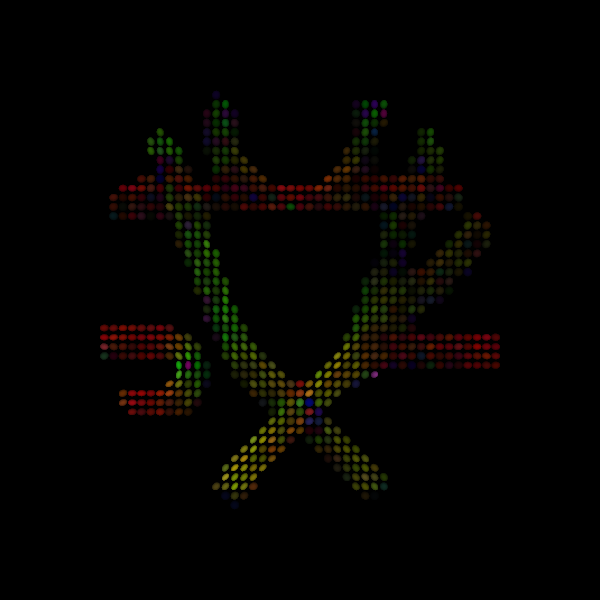

In [ ]:
## visualising the tensors with Dipy - won't work in colab
'''
! pip install fury
! pip install dipy

from dipy.data import get_sphere

sphere = get_sphere(name="repulsion724")

from dipy.viz import actor, window

# Enables/disables interactive visualization
interactive = False

scene = window.Scene()

# calculate the eigenvectors and eigenvalues of the diffusion tensor
evals, evecs = zip(*[np.linalg.eig(D_estimates[:,:,i]) for i in range(Nvox)])

# reshape evals to x,y,z,3
evals_reshape = np.zeros([mask.shape[0],mask.shape[1],mask.shape[2],3])
evals_reshape[idx[0],idx[1],idx[2],:] = evals
evals_reshape.shape

# reshape evecs to x,y,z,3,3
evecs_reshape = np.zeros([mask.shape[0],mask.shape[1],mask.shape[2],3,3])
evecs_reshape[idx[0],idx[1],idx[2],:,:] = evecs
evecs_reshape.shape

from dipy.reconst.dti import color_fa, fractional_anisotropy

# calculate fractional anisotropy to colour the tensors
FA = fractional_anisotropy(evals_reshape)

FA = np.clip(FA, 0, 1)
FA = FA / FA.max() # normalise to improve contrast
RGB = color_fa(FA, evecs_reshape)

scene.add(
    actor.tensor_slicer(evals_reshape, evecs_reshape, scalar_colors=RGB, sphere=sphere,  mask=mask, scale=0.5)
)

if interactive:
    window.show(scene, size=(800, 800), reset_camera=False)

else:
    window.record(
    scene=scene, n_frames=1, out_path="tensor_ellipsoids.png", size=(600, 600)
)
'''


# bonus exercise

Well done, you have estimated the diffusion tensor in each voxel of the data using non-linear least squares!

Now that we have this estimated tensor, we might be interested in understanding how well it fits the data, which will enable us to compare the fit of the diffusion tensor to other models.

Can you calculate the diffusion signal in each voxel from the diffusion tensor, and calculate the error between this diffusion tensor signal and the signal which we estimated the diffusion tensor from? How does the fit change across different voxels?